In [3]:
import numpy as np
import pandas as pd

import sklearn as sk

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

In [6]:

ratings_table = pd.read_csv(filepath_or_buffer='./ml-1m/ratings.dat',
                            sep='::', delimiter=None, header=0, engine='python')

# 1.
mean_rating_global = ratings_table['Rating'].mean()
# 2.
mean_rating_per_movie = ratings_table.groupby('MovieID')['Rating'].mean()
# .3
mean_rating_per_user = ratings_table.groupby('UserID')['Rating'].mean()


def generate_X_set(columns, *features):
    matrix = np.vstack(features[:2]).T
    X_set = pd.DataFrame(data=matrix, columns=columns)
    return X_set
    
X = generate_X_set(['UserID', 'MovieID'],*[ratings_table['UserID'], ratings_table['MovieID']])

X_per_movie = generate_X_set(['MovieID', 'UserID'],*[ratings_table['UserID'], ratings_table['MovieID'], mean_rating_per_movie])


In [7]:
X_global = X.copy()

X_global['global_average'] = mean_rating_global

X_per_user = pd.merge(left=X, right=mean_rating_per_user, how='left', 
              left_on='UserID', right_index=True)

X_per_movie = pd.merge(left=X, right=mean_rating_per_movie, how='left', 
              left_on='MovieID', right_index=True)

X_per_user_and_movie = pd.merge(left=X_per_user, right=mean_rating_per_movie, how='left', 
              left_on='MovieID', right_index=True)

y = ratings_table['Rating']

In [8]:
from re import T
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def k_fold_split_training(X, y, intercept=False): 
    
    kf = KFold(n_splits=5, shuffle=True, random_state=32)
    rmse = []
    for train_index, test_index in kf.split(X):
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        linear_reg = LinearRegression(fit_intercept=intercept)

        linear_reg.fit(X_train, y_train)
        
        y_predict = linear_reg.predict(X_test)

        rmse.append(np.sqrt(mean_squared_error(y_test, y_predict)))
        # The mean squared error
        print("Mean squared error: %.3f" % mean_squared_error(y_test, y_predict))
        # The root mean squared error
        print("Root mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test, y_predict)))
        # The mean absolute error
        print("Mean absolute error: %.3f" % mean_absolute_error(y_test, y_predict))
        # The coefficient of determination: 1 is perfect prediction
        print("Coefficient of determination: %.3f" % r2_score(y_test, y_predict))
        
        
    return rmse


In [ ]:
total_rmses = []

total_rmses.append(k_fold_split_training(X_global, y))
total_rmses.append(k_fold_split_training(X_per_user, y))
total_rmses.append(k_fold_split_training(X_per_movie, y))
total_rmses.append(k_fold_split_training(X_per_user_and_movie, y))
total_rmses.append(k_fold_split_training(X_per_user_and_movie, y, True))

total_rmses = np.array(total_rmses)

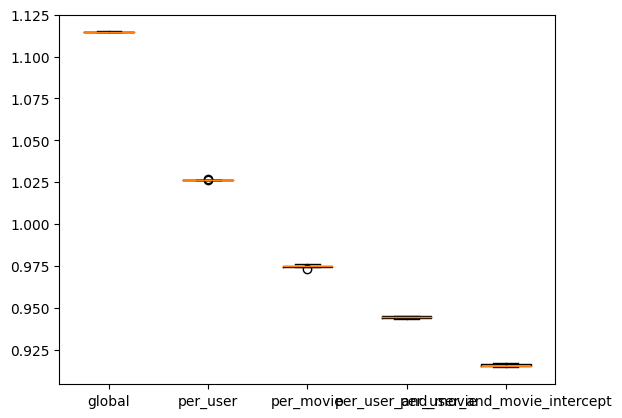

In [12]:
plt.boxplot(total_rmses.T, labels=['global', 'per_user', 'per_movie', 'per_user_and_movie', 'per_user_and_movie_intercept'])
plt.show()